Loading and Plotting surface EMG Data
=====================================

Here we show how to load and visualize EMG data collected at the wrist as described in the paper ["A generic non-invasive neuromotor interface for human-computer interaction"](https://www.nature.com/articles/s41586-025-09255-w). We will show examples from each of the three tasks described in the paper: `discrete_gestures`, `handwriting`, and `wrist`.

# Quick start for tidy data

**Prerequisite files:**
- **Recordings:** `.hdf5` files of the recordings, e.g., `discrete_gestures_user_002_dataset_000.hdf5`
- **Metadata:** called `discrete_gestures_corpus.csv`

As written, the code below assumes the above files are in the same folder called `emg_data`.

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from datetime import datetime

# Import the data loader from the generic_neuromotor_interface package
from generic_neuromotor_interface.explore_data.load import load_data

# First download the data, as described in the `README` or via the below cells.
# If necessary, set the `DATA_FOLDER` below to the location of the files.
# Set the folder where your EMG data is stored
DATA_FOLDER = "~/emg_data/"

# Path to the ground truth csv file (contains metadata for each recording)
corpus_csv = os.path.expanduser("~/emg_data/discrete_gestures_corpus.csv")
corpus_df = pd.read_csv(corpus_csv)  # Load the CSV into a pandas DataFrame

# Next we'll select [one of] the `discrete_gestures` files.
# Function to get all .hdf5 files for a given task (e.g., "discrete_gestures")
def get_task_dataset_paths(task: str) -> list[str]:
    folder = os.path.expanduser(DATA_FOLDER)
    datasets = glob.glob(os.path.join(folder, '*.hdf5'))
    # Only return files that contain the task name in their filename
    return [d for d in datasets if task in d]

# Get all discrete_gestures .hdf5 files in the data folder
files = get_task_dataset_paths("discrete_gestures")

# (OPTIONAL) Run this instead of the above to keep only the first three files for user_000, dataset_000/001/002, to run a smaller dataset
# files = [f for f in files if any(
#     f"user_000_dataset_00{i}.hdf5" in f for i in range(3)
# )]

# Store all the rows for our final dataframe
all_rows = []

# Print start time for the loop
print("Loop will start now. Start time:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# Loop through each .hdf5 file, printing a message when starting a new file
for file in files:
    basename = os.path.basename(file)  # Get just the filename (not the full path)
    print(f"Processing new file: {basename}")  # Print when starting a new file

    parts = basename.split('_')
    user_number = parts[3]  # Extract user_number from filename
    dataset_number = parts[5].split('.')[0]  # Extract dataset_number from filename

    # Find the matching row in the ground truth csv for this file
    gt_row = corpus_df[
        (corpus_df['user_number'].astype(str).str.zfill(3) == user_number) &
        (corpus_df['dataset_number'].astype(str).str.zfill(3) == dataset_number)
    ]
    gt_row = gt_row.iloc[0]  # Get the first (and only) matching row
    start, end, split = gt_row['start'], gt_row['end'], gt_row['split']

    # We'll load the file using the `load_data` utility function.
    # Load the EMG data and associated info from single .hdf5 file
    data = load_data(file)
    emg = data.emg         # EMG signal, shape: (n_samples, 16)
    time = data.time       # Timestamps for each sample
    prompts = data.prompts # Dataframe of gesture events (name, time)
    stages = data.stages   # Dataframe of stage events (start, end, name)

    # Prepare an array to hold the gesture label for each sample (default: empty string)
    gesture_labels = np.full_like(time, '', dtype=object)
    if not prompts.empty:
        prompt_times = prompts['time'].values
        prompt_names = prompts['name'].values
        prompt_idx = 0
        # For each sample, check if a gesture occurs at that timestamp
        for i, t in enumerate(time):
            while prompt_idx + 1 < len(prompt_times) and prompt_times[prompt_idx + 1] <= t:
                prompt_idx += 1
            if prompt_times[prompt_idx] == t:
                gesture_labels[i] = prompt_names[prompt_idx]

    # Prepare an array to hold the stage label for each sample (default: empty string)
    stage_labels = np.full_like(time, '', dtype=object)
    if not stages.empty:
        # For each sample, check if it falls within any stage interval
        for i, t in enumerate(time):
            for _, row in stages.iterrows():
                if row['start'] <= t <= row['end']:
                    stage_labels[i] = row['name']
                    break

    # For each sample in the EMG recording, build a row for the output dataframe
    for i in range(emg.shape[0]):
        row = [
            start, end, split, dataset_number, user_number, basename,  # Keep .hdf5 extension in 'dataset'
            time[i], stage_labels[i], gesture_labels[i]
        ] + emg[i].tolist()  # Add all 16 EMG channel values
        all_rows.append(row)

# Create column names for EMG channels (emg_00, emg_01, ..., emg_15)
emg_cols = [f"emg_{i:02d}" for i in range(16)]
columns = [
    "start", "end", "split", "dataset_number", "user_number", "dataset",
    "time", "stage", "gesture"
] + emg_cols

# Build the final dataframe
df = pd.DataFrame(all_rows, columns=columns)

# Print the shape of the dataframe (rows, columns)
print(df.shape)

# Preview the first 10 rows
df.head(10)

## Save options

In [ ]:
# To save the dataframe as a csv file, uncomment and run:
# df.to_csv("discrete_gestures_long.csv", index=False)

In [ ]:
# Optionally, save only the first 1000 rows to a CSV file
# df.head(1000).to_csv("first_1000_rows.csv", index=False)

In [ ]:
# Optionally, save 1000 rows where at least one non-empty cell in "gesture" appears
# Here, the non-empty "gesture" will show up in the 10th row
# # Find the first non-empty gesture row
# gesture_idx = df.index[df['gesture'] != ''][0]

# # Determine where to start the slice
# if gesture_idx < 100:
#     start_idx = 0
# else:
#     start_idx = gesture_idx - 9
# start_idx = max(start_idx, 0)

# # Select and save the first 1000 rows (with at least one gesture)
# df_slice = df.iloc[start_idx : start_idx + 1000]
# df_slice.to_csv("first_gesture_1000_rows.csv", index=False)

# # Optional preview
# print(df_slice.head(10))

# Setup

First download the data, as described in the `README` or via the below cells.

If necessary, set the `DATA_FOLDER` below to the location of the files.

In [1]:
DATA_FOLDER = "~/emg_data/"

In [2]:
from generic_neuromotor_interface.scripts.download_data import download_data

for task in ["discrete_gestures", "handwriting", "wrist"]:
    download_data(task, "small_subset", DATA_FOLDER)

Found data downloaded for task_name='discrete_gestures', dataset='small_subset' at data_dir=PosixPath('/Users/sero/emg_data'). Last modified: 2025-09-15 14:54:55.876279. Assuming data already downloaded!
Found data downloaded for task_name='handwriting', dataset='small_subset' at data_dir=PosixPath('/Users/sero/emg_data'). Last modified: 2025-09-16 11:29:47.907711. Assuming data already downloaded!
Found data downloaded for task_name='wrist', dataset='small_subset' at data_dir=PosixPath('/Users/sero/emg_data'). Last modified: 2025-09-16 11:12:12.897803. Assuming data already downloaded!


In [3]:
from generic_neuromotor_interface.explore_data.plot import plot_emg, plot_wrist
from generic_neuromotor_interface.explore_data.load import load_data
from generic_neuromotor_interface.constants import Task
from IPython.display import display
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd


def get_task_dataset_paths(task: Task) -> list[str]:
    """Get full paths to all datasets for a given task."""
    folder = os.path.expanduser(DATA_FOLDER)
    datasets = glob.glob(os.path.join(folder, '*.hdf5'))
    return [d for d in datasets if task in d]

# Loading data

Next we'll select one of the `discrete_gestures` files.

In [4]:
file = get_task_dataset_paths("discrete_gestures")[0]
print("Selected file:", os.path.basename(file))

Selected file: discrete_gestures_user_002_dataset_000.hdf5


We'll load the file using the `load_data` utility function.

In [5]:
data = load_data(file)
data

The file contains a task identifier, EMG, timestamps, a `stages` dataframe with the timing of the different experimental stages, and a `prompts` dataframe with the timing of all the gestures:.

In [6]:
print("task:            ", data.task)
print("emg shape:       ", data.emg.shape)
print("timestamp shape: ", data.time.shape)
print("stages:")
display(data.stages.head())
print("prompts:")
display(data.prompts)

task:             discrete_gestures
emg shape:        (5548256, 16)
timestamp shape:  (5548256,)
stages:


,start,end,name
0,1.634052e+09,1.634052e+09,pinch_release_practice
1,1.634052e+09,1.634052e+09,pinch_release_static_hand_in_lap_with_taps
2,1.634052e+09,1.634052e+09,pinch_release_static_vertical_arm_with_taps
3,1.634052e+09,1.634052e+09,pinch_release_static_palm_up_with_taps
4,1.634052e+09,1.634052e+09,pinch_release_static_palm_out_with_taps


prompts:


,name,time
0,middle_press,1.634052e+09
1,middle_release,1.634052e+09
2,index_press,1.634052e+09
3,index_release,1.634052e+09
4,index_press,1.634052e+09
...,...,...
1895,middle_press,1.634054e+09
1896,middle_release,1.634054e+09
1897,thumb_in,1.634054e+09
1898,middle_press,1.634054e+09


# Plotting data

## Discrete Gestures

Here we plot EMG snippets for a single `discrete_gestures` dataset in 1 second windows centered on different gesture types.

Notice the use of `gesture_data.partition(start_time, end_time)` to extract windows of EMG around events of interest.

In [7]:
discrete_gestures_file = get_task_dataset_paths("discrete_gestures")[0]
print("Selected file:", os.path.basename(discrete_gestures_file))

discrete_gestures_data = load_data(discrete_gestures_file)

Selected file: discrete_gestures_user_002_dataset_000.hdf5


In [8]:
## Inspect discrete_gestures_data
dir(discrete_gestures_data)
# help(discrete_gestures_data)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'emg',
 'hdf5_path',
 'partition',
 'prompts',
 'stages',
 'task',
 'time',
 'timeseries']

In [9]:
## Inspect emg, partition, prompts, stages, task, time, and timeseries
print("emg:", type(discrete_gestures_data.emg), discrete_gestures_data.emg.shape)
print("time:", type(discrete_gestures_data.time), discrete_gestures_data.time.shape)
print("prompts:", type(discrete_gestures_data.prompts))
print(discrete_gestures_data.prompts.head())
print("stages:", type(discrete_gestures_data.stages))
print(discrete_gestures_data.stages.head())
print("task:", discrete_gestures_data.task)
print("timeseries:", type(discrete_gestures_data.timeseries))

emg: <class 'numpy.ndarray'> (5548256, 16)
time: <class 'numpy.ndarray'> (5548256,)
prompts: <class 'pandas.core.frame.DataFrame'>
             name          time
0    middle_press  1.634052e+09
1  middle_release  1.634052e+09
2     index_press  1.634052e+09
3   index_release  1.634052e+09
4     index_press  1.634052e+09
stages: <class 'pandas.core.frame.DataFrame'>
          start           end                                         name
0  1.634052e+09  1.634052e+09                       pinch_release_practice
1  1.634052e+09  1.634052e+09   pinch_release_static_hand_in_lap_with_taps
2  1.634052e+09  1.634052e+09  pinch_release_static_vertical_arm_with_taps
3  1.634052e+09  1.634052e+09       pinch_release_static_palm_up_with_taps
4  1.634052e+09  1.634052e+09      pinch_release_static_palm_out_with_taps
task: discrete_gestures
timeseries: <class 'numpy.ndarray'>


In [10]:
# What are the unique "name"s in "prompts"?
unique_prompt_names = discrete_gestures_data.prompts['name'].unique()
print("Unique gesture names in prompts:")
print(unique_prompt_names)

Unique gesture names in prompts:
['middle_press' 'middle_release' 'index_press' 'index_release' 'thumb_out'
 'thumb_down' 'thumb_in' 'thumb_up' 'thumb_click']


In [11]:
# What are the unique "name"s in "stages"?
unique_stage_names = discrete_gestures_data.stages['name'].unique()
print("Unique stage names in stages:")
print(unique_stage_names)

Unique stage names in stages:
['pinch_release_practice' 'pinch_release_static_hand_in_lap_with_taps'
 'pinch_release_static_vertical_arm_with_taps'
 'pinch_release_static_palm_up_with_taps'
 'pinch_release_static_palm_out_with_taps'
 'pinch_release_dynamic_vertical_arm_translation' 'thumb_swipes_practice'
 'thumb_swipes_static_arm_in_lap' 'thumb_swipes_static_arm_front'
 'thumb_swipes_static_vertical' 'null'
 'pinch_release_thumb_swipes_practice'
 'pinch_release_thumb_swipes_static_vertical_arm'
 'pinch_release_thumb_swipes_static_arm_in_front']


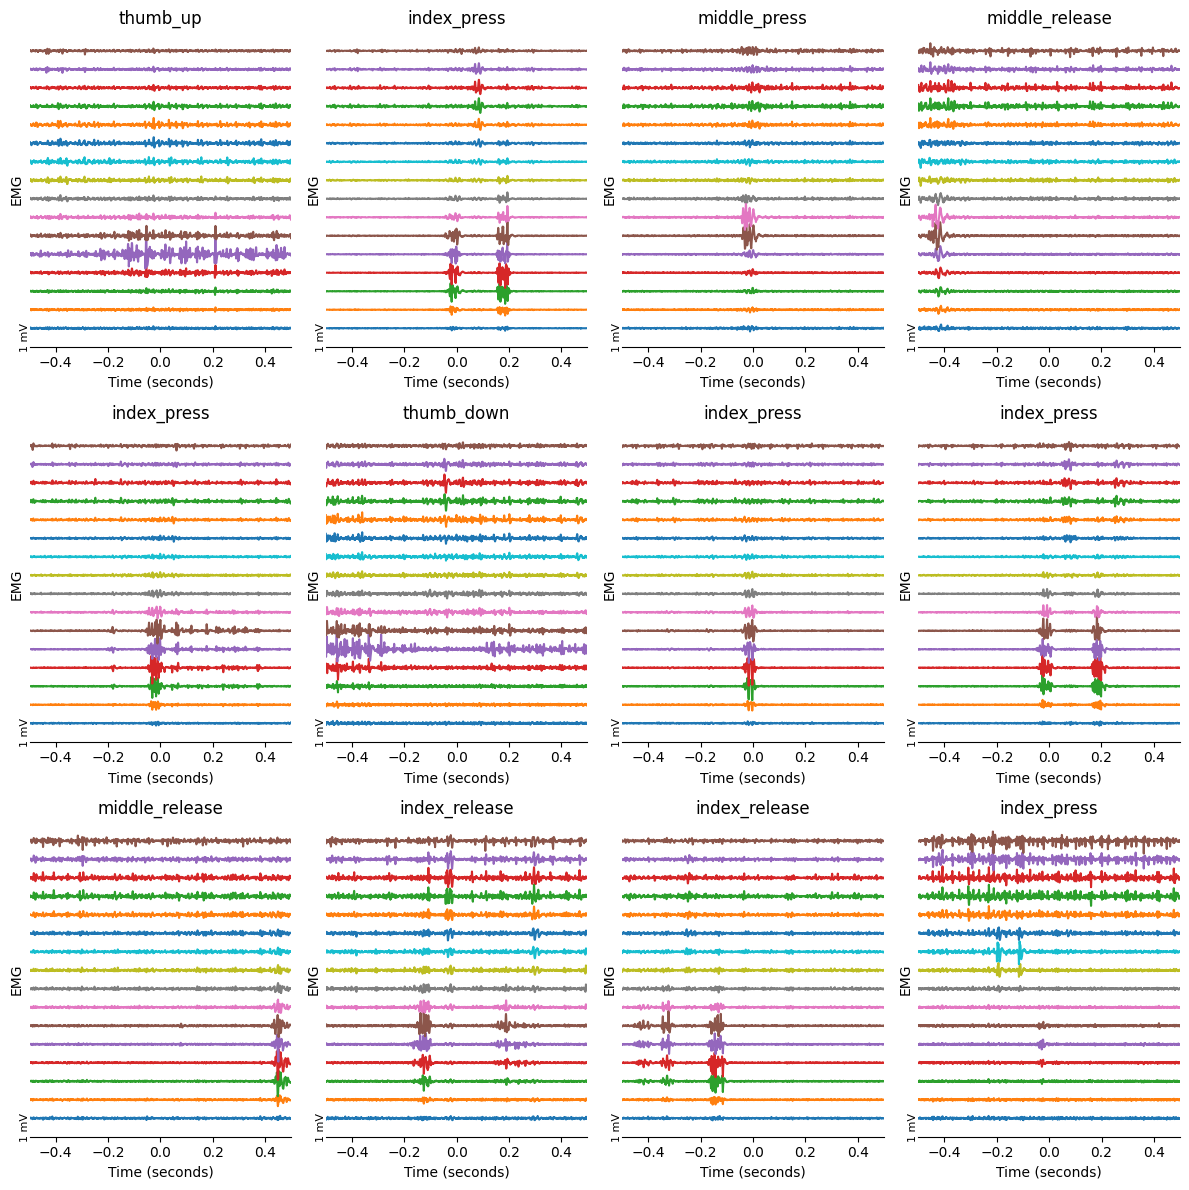

In [12]:
window = [-.5, 1.5]
nrows = 3
ncols = 4

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 4))

# Sample random gestures
sampled_gestures = discrete_gestures_data.prompts.sample(
    nrows * ncols,
    random_state=2,
    replace=False
)

for ax, (_, gesture) in zip(axs.flatten(), sampled_gestures.iterrows()):
    timeseries = discrete_gestures_data.partition(
        start_t=gesture.time + window[0],
        end_t=gesture.time + window[1]
    )
    plot_emg(
        timeseries["time"] - gesture.time,
        timeseries["emg"],
        normalize_time=False,
        ax=ax
    )
    gesture_name = gesture.loc["name"]
    ax.set(title=f"{gesture_name}")

plt.tight_layout()

## View only 1 discrete gesture at all channels

<Figure size 800x400 with 0 Axes>

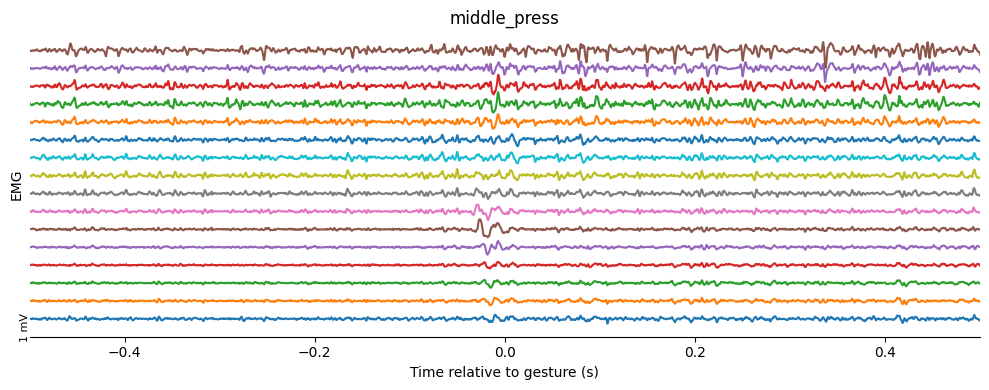

In [13]:
# Pick the first available gesture
gesture = discrete_gestures_data.prompts.iloc[0]

# Extract the EMG window around the gesture
window = [-.5, .5]  # seconds before and after the gesture
timeseries = discrete_gestures_data.partition(
    start_t=gesture.time + window[0],
    end_t=gesture.time + window[1]
)

## Plot the EMG for this window
plt.figure(figsize=(8, 4))
plot_emg(
    timeseries["time"] - gesture.time,
    timeseries["emg"],
    normalize_time=False
)
plt.title(gesture["name"])
plt.xlabel("Time relative to gesture (s)")
plt.tight_layout()
plt.show()


## View only 1 discrete gesture at only 1 channel

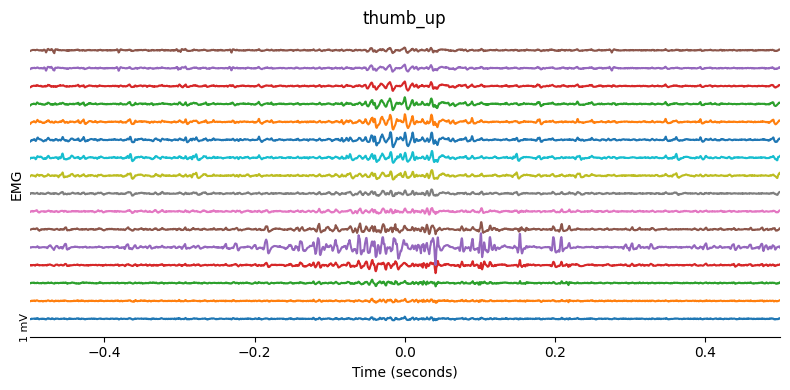

In [14]:
# Pick specifically "thumb_up"
gesture_row = discrete_gestures_data.prompts[discrete_gestures_data.prompts['name'] == 'thumb_up'].iloc[0]

window = [-0.5, 0.5]  # 0.5 seconds before and after the gesture
center_time = gesture_row.time

# Get the EMG data for this window
timeseries = discrete_gestures_data.partition(
    start_t=center_time + window[0],
    end_t=center_time + window[1]
)

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
plot_emg(
    timeseries["time"] - center_time,  # Time relative to gesture
    timeseries["emg"],
    normalize_time=False,
    ax=ax
)
ax.set(title="thumb_up")
plt.tight_layout()
plt.show()

## Plot only one channel of one gesture

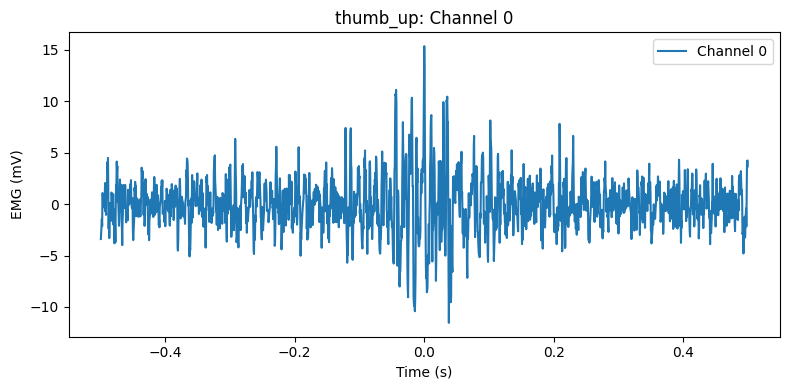

In [15]:
# Find the first "thumb_up" gesture
gesture_row = discrete_gestures_data.prompts[discrete_gestures_data.prompts['name'] == 'thumb_up'].iloc[0]
center_time = gesture_row.time
window = [-0.5, 0.5]

# Extract the time window around the gesture
timeseries = discrete_gestures_data.partition(
    start_t=center_time + window[0],
    end_t=center_time + window[1]
)
# timeseries["emg"] is a 2D array: (samples, channels)
# timeseries["time"] is a 1D array: (samples,)

# Plot a single channel, e.g., channel 0 (the first electrode):
channel_idx = 0  # Change this to plot a different channel (0-based index)
plt.figure(figsize=(8, 4))
plt.plot(
    timeseries["time"] - center_time,
    timeseries["emg"][:, channel_idx],
    label=f'Channel {channel_idx}'
)
plt.xlabel('Time (s)')
plt.ylabel('EMG (mV)')
plt.title('thumb_up: Channel 0')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# View the plotted data above as a dataframe
# Calculate time relative to the gesture
relative_time = timeseries["time"] - center_time
emg_values = timeseries["emg"][:, channel_idx]

# Create the DataFrame
df_plot = pd.DataFrame({
    'time_relative_to_gesture': relative_time,
    f'channel_{channel_idx+1}_emg': emg_values
})

print(df_plot.shape)
print(df_plot.head())

(1999, 2)
   time_relative_to_gesture  channel_1_emg
0                 -0.499504      -3.392956
1                 -0.499004      -2.658342
2                 -0.498504      -2.008302
3                 -0.498004      -1.437893
4                 -0.497504      -2.143173


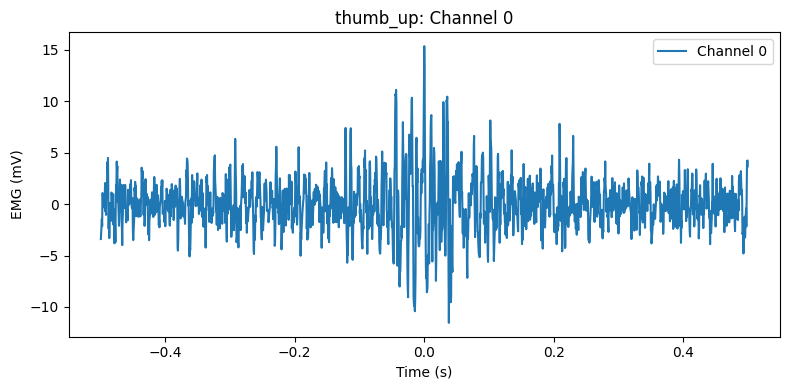

   time_relative_to_gesture  emg_channel_0
0                 -0.499504      -3.392956
1                 -0.499004      -2.658342
2                 -0.498504      -2.008302
3                 -0.498004      -1.437893
4                 -0.497504      -2.143173


In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Find the first "thumb_up" gesture
gesture_row = discrete_gestures_data.prompts[discrete_gestures_data.prompts['name'] == 'thumb_up'].iloc[0]
center_time = gesture_row.time
window = [-0.5, 0.5]

# Extract the time window around the gesture
timeseries = discrete_gestures_data.partition(
    start_t=center_time + window[0],
    end_t=center_time + window[1]
)

# Select the channel to plot and show as DataFrame
channel_idx = 0  # Change this to plot a different channel (0-based index)
relative_time = timeseries["time"] - center_time
emg_channel = timeseries["emg"][:, channel_idx]

# Plot the data
plt.figure(figsize=(8, 4))
plt.plot(relative_time, emg_channel, label=f'Channel {channel_idx}')
plt.xlabel('Time (s)')
plt.ylabel('EMG (mV)')
plt.title('thumb_up: Channel 0')
plt.legend()
plt.tight_layout()
plt.show()

# Show the data as a DataFrame
df_channel = pd.DataFrame({
    'time_relative_to_gesture': relative_time,
    f'emg_channel_{channel_idx}': emg_channel
})
print(df_channel.head(5))  # Show the first few rows